# **DATA TEST AUGMENTASI DAN TRAINING MENGGUNAKAN DATA AUGMENTASI ASLI**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import cv2 as cv
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

In [ ]:
path = "/content/drive/MyDrive/Skripsi_Dataset/Dataset_Augmented/Data Train Gabungan"
test_dir = "/content/drive/MyDrive/Skripsi_Dataset/Dataset_Augmented/Data_Test"

In [ ]:
key_value = dict()
for i in os.listdir(path):
    key_value[i] = os.listdir(os.path.join(path, i))

df = []
for key in key_value.keys():
    for j in key_value[key]:
        df.append([key, os.path.join(path, key, j)])
df1 = pd.DataFrame(df, columns=('label', 'path'))
print("Total gambar training:", len(df1))

Total gambar training: 1649


In [ ]:
def readimg(path):
    img = cv.imread(path)
    img = cv.resize(img, (224, 224))
    return img

In [ ]:
import multiprocessing
with multiprocessing.Pool(4) as p:
    images = p.map(readimg, df1['path'])

images = np.array(images, dtype='float')
le = preprocessing.LabelEncoder()
y_labels = le.fit_transform(df1['label'])

In [ ]:
key_value_test = dict()
for i in os.listdir(test_dir):
    key_value_test[i] = os.listdir(os.path.join(test_dir, i))

df_test = []
for key in key_value_test.keys():
    for j in key_value_test[key]:
        df_test.append([key, os.path.join(test_dir, key, j)])
df_test = pd.DataFrame(df_test, columns=('label', 'path'))
print("Total gambar test:", len(df_test))

Total gambar test: 413


In [ ]:
with multiprocessing.Pool(4) as p:
    test_images = p.map(readimg, df_test['path'])

test_images = np.array(test_images, dtype='float')
test_labels = le.transform(df_test['label'])

In [ ]:
train_images, val_images, train_labels, val_labels = train_test_split(
    images, y_labels, test_size=0.2, random_state=1
)

In [ ]:
print(f"Jumlah total data training: {len(train_images)}")
print(f"Jumlah total data validation: {len(val_images)}")
print(f"Jumlah total data test: {len(test_images)}")

Jumlah total data training: 1319
Jumlah total data validation: 330
Jumlah total data test: 413


In [ ]:
## implementing trensfer learning
base_model = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# freezing the base model so we donot have to train it again
base_model.trainable = False


model = keras.Sequential([
  base_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(1024, activation='relu'),
  keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer='adam', loss='SparseCategoricalCrossentropy', metrics=['accuracy'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
history = model.fit(
    train_images, train_labels,
    epochs=50,
    batch_size=32,
    validation_data=(val_images, val_labels),
    shuffle=True
)

Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 32s 436ms/step - accuracy: 0.3938 - loss: 3.5023 - val_accuracy: 0.7576 - val_loss: 0.8043
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 185ms/step - accuracy: 0.8664 - loss: 0.3655 - val_accuracy: 0.8667 - val_loss: 0.4332
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 184ms/step - accuracy: 0.9315 - loss: 0.1937 - val_accuracy: 0.8939 - val_loss: 0.3651
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 187ms/step - accuracy: 0.9871 - loss: 0.0666 - val_accuracy: 0.9121 - val_loss: 0.3122
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 188ms/step - accuracy: 0.9982 - loss: 0.0367 - val_accuracy: 0.9000 - val_loss: 0.3327
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 189ms/step - accuracy: 0.9981 - loss: 0.0331 - val_accuracy: 0.9121 - val_loss: 0.2777
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 191ms/step - accuracy: 1.0000 - loss: 0.0159 - val_accuracy: 0.9061 - val_loss: 0.2858
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 191ms/step - accuracy: 1.0000 - loss: 0.0099 - val_accuracy: 0

In [ ]:
# ===================== SIMPAN HISTORY KE CSV ============================
# Mengubah history ke DataFrame
hist_df = pd.DataFrame(history.history)

# Menentukan path penyimpanan di Google Drive
csv_path = "/content/drive/MyDrive/Skripsi_Dataset/Csv Training/VGG16_TL_TrainAug.csv"

# Simpan ke CSV
hist_df.to_csv(csv_path, index=False)

print(f"Hasil training telah disimpan ke: {csv_path}")

Hasil training telah disimpan ke: /content/drive/MyDrive/Skripsi_Dataset/Csv Training/VGG16_TL_TrainAug.csv


In [ ]:
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step


Text(0.5, 1.0, 'Confusion Matrix')

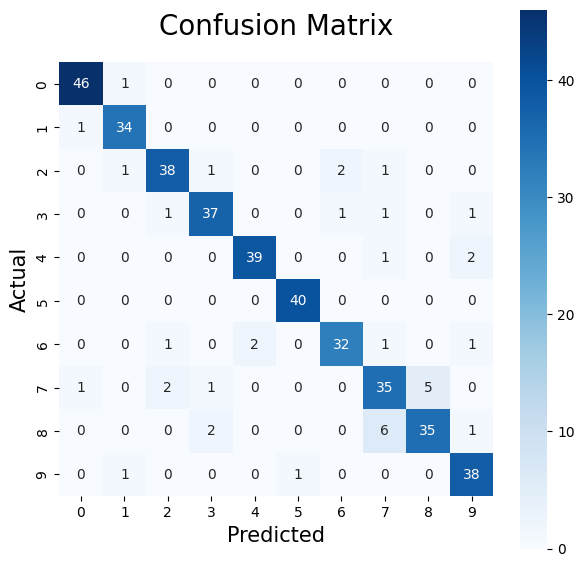

In [ ]:
numer_type = [str(i) for i in range(10)]
fig, ax = plt.subplots(figsize=(7,7))
cm = confusion_matrix(test_labels, predicted_labels)
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True,
            square=True, xticklabels=numer_type,
            yticklabels=numer_type, ax=ax)
ax.set_ylabel('Actual', fontsize=15)
ax.set_xlabel('Predicted', fontsize=15)
ax.set_title('Confusion Matrix', fontsize=20, pad=20)

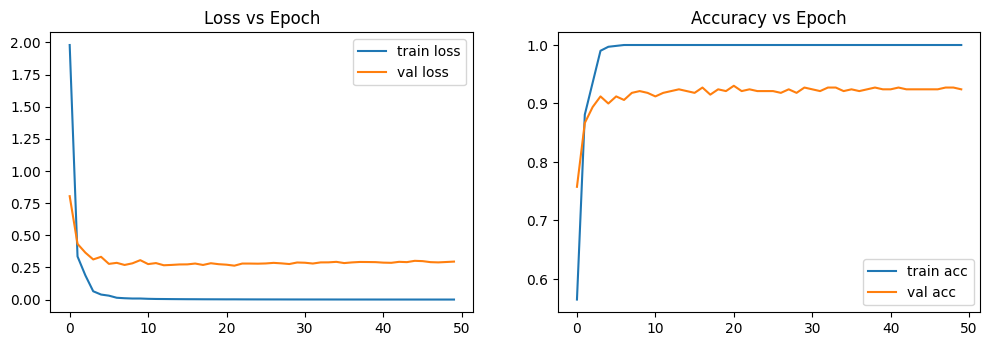

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss vs Epoch')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy vs Epoch')
plt.show()

In [ ]:
target_class_names = [str(i) for i in range(10)]
print("\nClassification Report Data Test (Augmentasi):")
print(classification_report(test_labels, predicted_labels, target_names=target_class_names, digits=4))


Classification Report Data Test (Augmentasi):
              precision    recall  f1-score   support

           0     0.9583    0.9787    0.9684        47
           1     0.9189    0.9714    0.9444        35
           2     0.9048    0.8837    0.8941        43
           3     0.9024    0.9024    0.9024        41
           4     0.9512    0.9286    0.9398        42
           5     0.9756    1.0000    0.9877        40
           6     0.9143    0.8649    0.8889        37
           7     0.7778    0.7955    0.7865        44
           8     0.8750    0.7955    0.8333        44
           9     0.8837    0.9500    0.9157        40

    accuracy                         0.9056       413
   macro avg     0.9062    0.9071    0.9061       413
weighted avg     0.9055    0.9056    0.9050       413



In [ ]:
from sklearn.metrics import accuracy_score

# Make predictions on the test data
predictions = model.predict(test_images)

# Convert the predictions to the class labels
predicted_labels = np.argmax(predictions, axis=1)

# Compute the accuracy score
accuracy = accuracy_score(test_labels, predicted_labels)

print('Accuracy:', accuracy)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step
Accuracy: 0.9055690072639225


In [ ]:
from sklearn.metrics import precision_score

precision = precision_score(test_labels, predicted_labels, average='macro')

print('Precision:', precision)

Precision: 0.9062066871993133


In [ ]:
from sklearn.metrics import recall_score

recall= recall_score(test_labels, predicted_labels, average='macro')

print('Recall:', recall)

Recall: 0.9070657314652075


In [ ]:
from sklearn.metrics import f1_score

f1= f1_score(test_labels, predicted_labels, average='macro')

print('F1-Score:', f1)

F1-Score: 0.9061237252414541


In [ ]:
accuracy = accuracy_score(test_labels, predicted_labels)
precision = precision_score(test_labels, predicted_labels, average='macro')
recall = recall_score(test_labels, predicted_labels, average='macro')
f1 = f1_score(test_labels, predicted_labels, average='macro')

print("\n=== HASIL EVALUASI ===")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-Score : {f1:.4f}")


=== HASIL EVALUASI ===
Accuracy : 0.9056
Precision: 0.9062
Recall   : 0.9071
F1-Score : 0.9061


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,321,376 (62.26 MB)

 Trainable params: 535,562 (2.04 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 1,071,126 (4.09 MB)

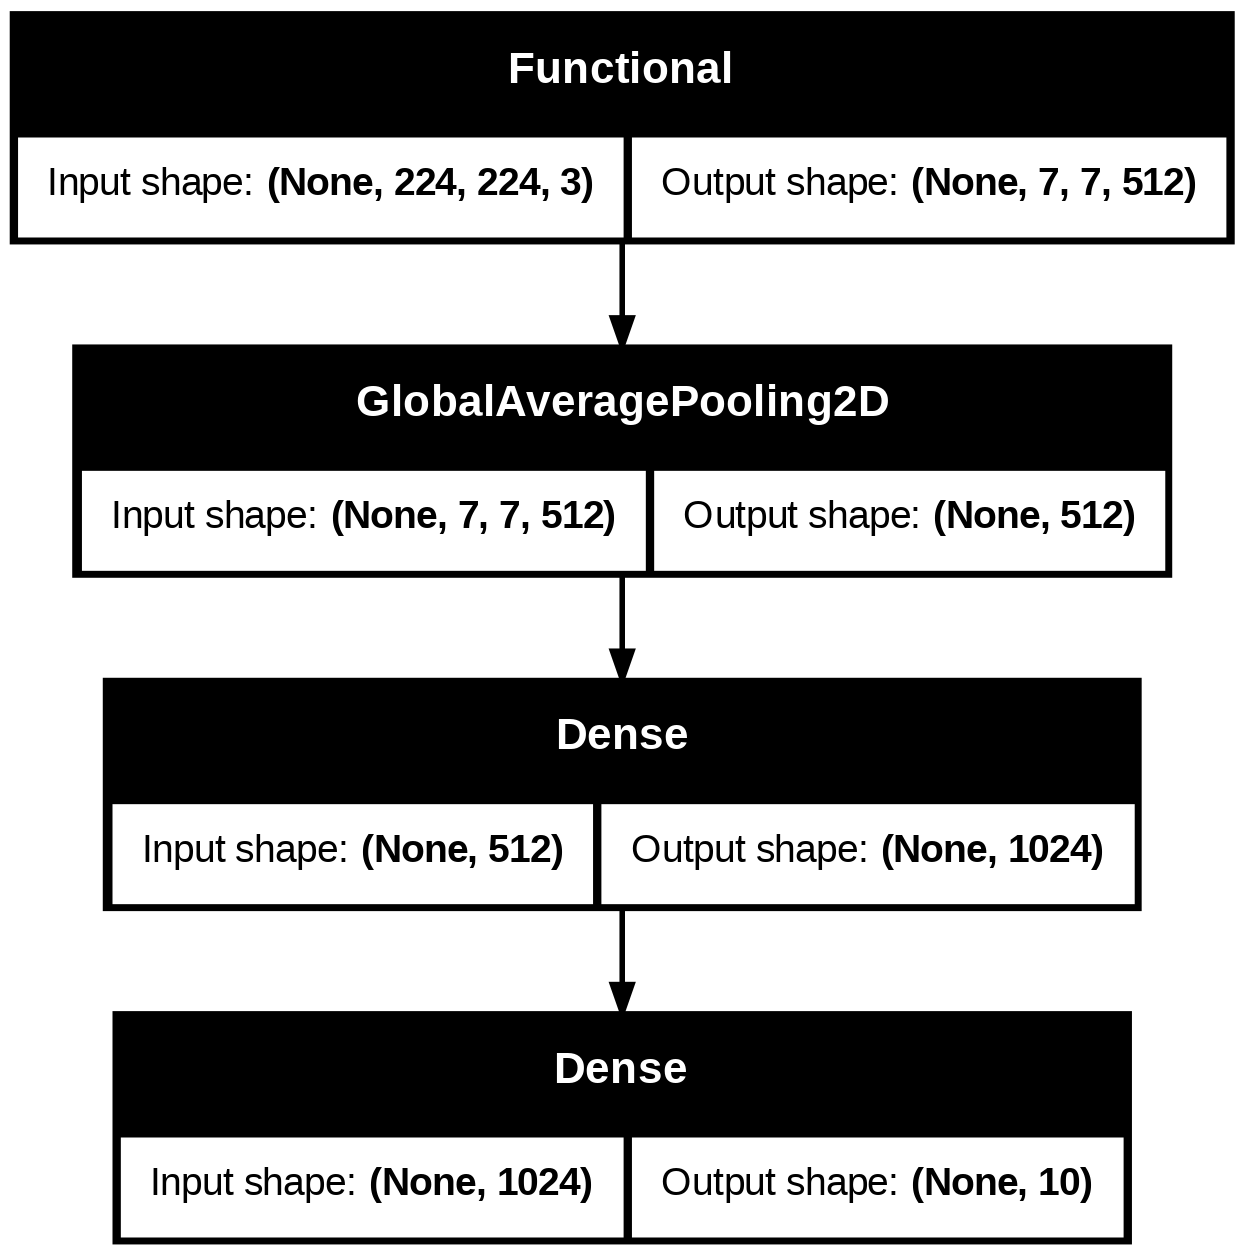

In [ ]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

Total prediksi benar: 374
Total prediksi salah: 39


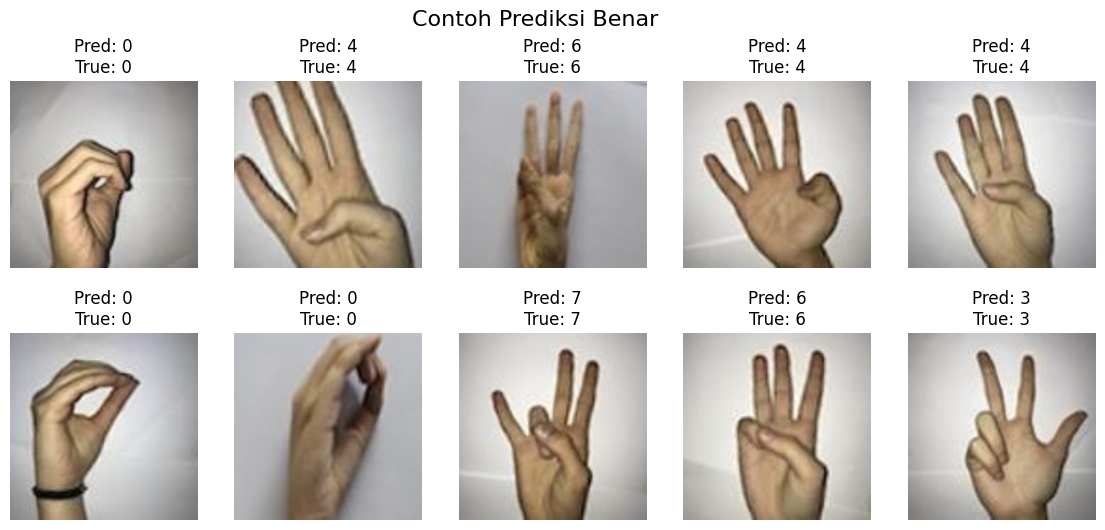

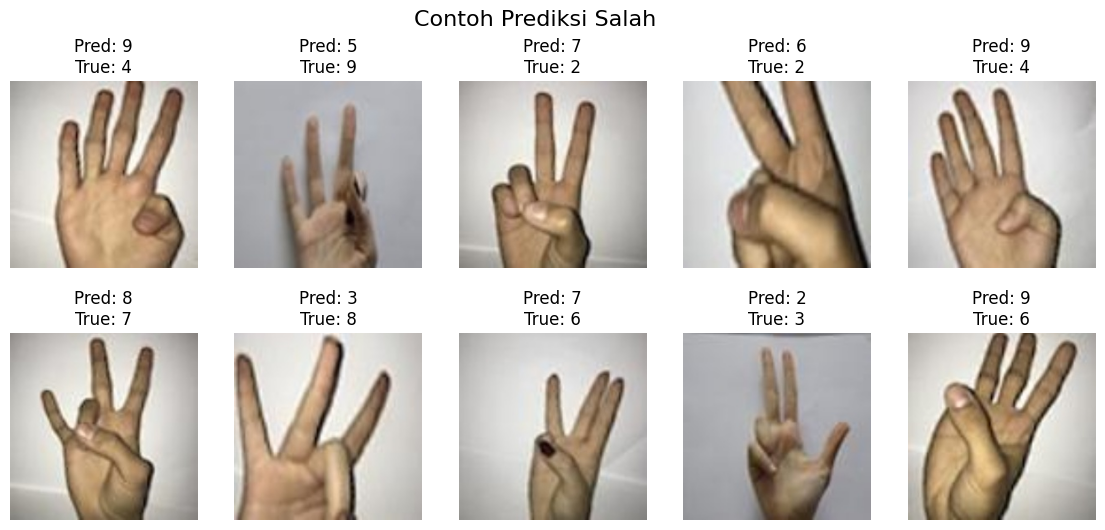

In [ ]:
# --- Tampilkan Prediksi Benar dan Salah ---
import random

# Buat array indeks prediksi benar dan salah
correct_idx = np.where(predicted_labels == test_labels)[0]
incorrect_idx = np.where(predicted_labels != test_labels)[0]

print(f"Total prediksi benar: {len(correct_idx)}")
print(f"Total prediksi salah: {len(incorrect_idx)}")

# Fungsi bantu untuk menampilkan gambar
def show_images(indices, title):
    plt.figure(figsize=(14, 6))
    for i, idx in enumerate(random.sample(list(indices), min(10, len(indices)))):  # tampilkan 10 contoh acak
        plt.subplot(2, 5, i + 1)
        img = cv.cvtColor(test_images[idx].astype('uint8'), cv.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(f"Pred: {le.classes_[predicted_labels[idx]]}\nTrue: {le.classes_[test_labels[idx]]}")
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.show()

# Tampilkan gambar prediksi benar
show_images(correct_idx, "Contoh Prediksi Benar")

# Tampilkan gambar prediksi salah
show_images(incorrect_idx, "Contoh Prediksi Salah")


In [ ]:
model.save('/content/drive/MyDrive/Skripsi_Dataset/Model Baru/VGG16_TL_TrainAug.keras')
print("Model berhasil disimpan dalam format .keras!")

model.save('/content/drive/MyDrive/Skripsi_Dataset/Model Baru/VGG16_TL_TrainAug.h5')
print("Model berhasil disimpan dalam format .h5!")

Model berhasil disimpan dalam format .keras!
Model berhasil disimpan dalam format .h5!


# **DATA TEST ASLI**

In [ ]:
import os
import numpy as np
import cv2 as cv
import pandas as pd
import tensorflow as tf
from sklearn import preprocessing
from sklearn.metrics import (
    confusion_matrix, classification_report,
    accuracy_score, precision_score, recall_score, f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
model_path = "/content/drive/MyDrive/Skripsi_Dataset/Model Baru/VGG16_TL_TrainAug.keras"
test_new_dir = "/content/drive/MyDrive/Skripsi_Dataset/Dataset/Test_Images"

In [ ]:
print("Memuat model yang sudah dilatih...")
model = tf.keras.models.load_model(model_path)
print("Model berhasil dimuat!")

Memuat model yang sudah dilatih...
Model berhasil dimuat!


In [ ]:
key_value_test_new = dict()
for i in os.listdir(test_new_dir):
    key_value_test_new[i] = os.listdir(os.path.join(test_new_dir, i))

In [ ]:
df_test_new = []
for key in key_value_test_new.keys():
    for j in key_value_test_new[key]:
        df_test_new.append([key, os.path.join(test_new_dir, key, j)])
df_test_new = pd.DataFrame(df_test_new, columns=('label', 'path'))
print("Total gambar test baru:", len(df_test_new))

Total gambar test baru: 413


In [ ]:
def readimg(path):
    img = cv.imread(path)
    img = cv.resize(img, (224, 224))
    return img

In [ ]:
import multiprocessing
with multiprocessing.Pool(4) as p:
    test_images_new = p.map(readimg, df_test_new['path'])

test_images_new = np.array(test_images_new, dtype='float')

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(df_test_new['label'])
test_labels_new = le.transform(df_test_new['label'])

In [ ]:
print("\n Melakukan prediksi pada data test baru...")
predictions_new = model.predict(test_images_new)
predicted_labels_new = np.argmax(predictions_new, axis=1)


 Melakukan prediksi pada data test baru...
13/13 ━━━━━━━━━━━━━━━━━━━━ 256s 20s/step


In [ ]:
accuracy = accuracy_score(test_labels_new, predicted_labels_new)
precision = precision_score(test_labels_new, predicted_labels_new, average='macro')
recall = recall_score(test_labels_new, predicted_labels_new, average='macro')
f1 = f1_score(test_labels_new, predicted_labels_new, average='macro')

In [ ]:
print("\n=== HASIL EVALUASI DATA TEST ASLI TANPA AUGMENTASI ===")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-Score : {f1:.4f}")


=== HASIL EVALUASI DATA TEST ASLI TANPA AUGMENTASI ===
Accuracy : 0.9128
Precision: 0.9146
Recall   : 0.9148
F1-Score : 0.9121


In [ ]:
target_class_names = le.classes_
print("\nClassification Report:")
print(classification_report(test_labels_new, predicted_labels_new, target_names=target_class_names, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.9792    1.0000    0.9895        47
           1     0.9722    1.0000    0.9859        35
           2     0.8298    0.9070    0.8667        43
           3     0.9524    0.9756    0.9639        41
           4     0.9487    0.8810    0.9136        42
           5     0.9744    0.9500    0.9620        40
           6     0.8333    0.9459    0.8861        37
           7     0.8235    0.6364    0.7179        44
           8     0.8600    0.9773    0.9149        44
           9     0.9722    0.8750    0.9211        40

    accuracy                         0.9128       413
   macro avg     0.9146    0.9148    0.9121       413
weighted avg     0.9138    0.9128    0.9107       413



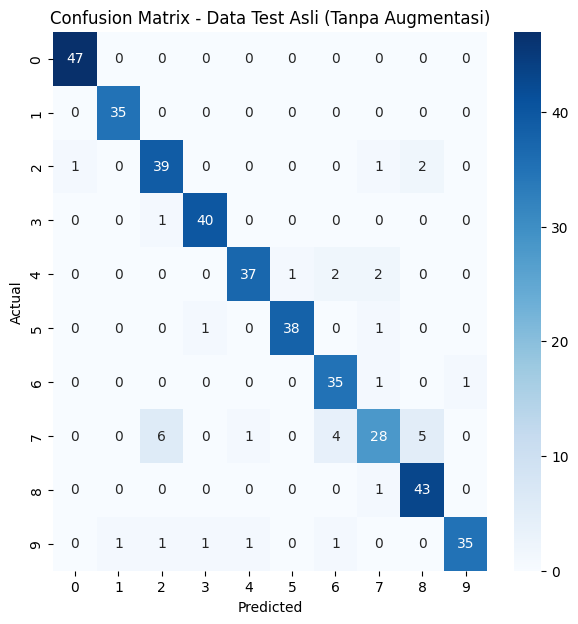

In [ ]:
plt.figure(figsize=(7,7))
cm = confusion_matrix(test_labels_new, predicted_labels_new)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g',
            xticklabels=target_class_names,
            yticklabels=target_class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Data Test Asli (Tanpa Augmentasi)")
plt.show()

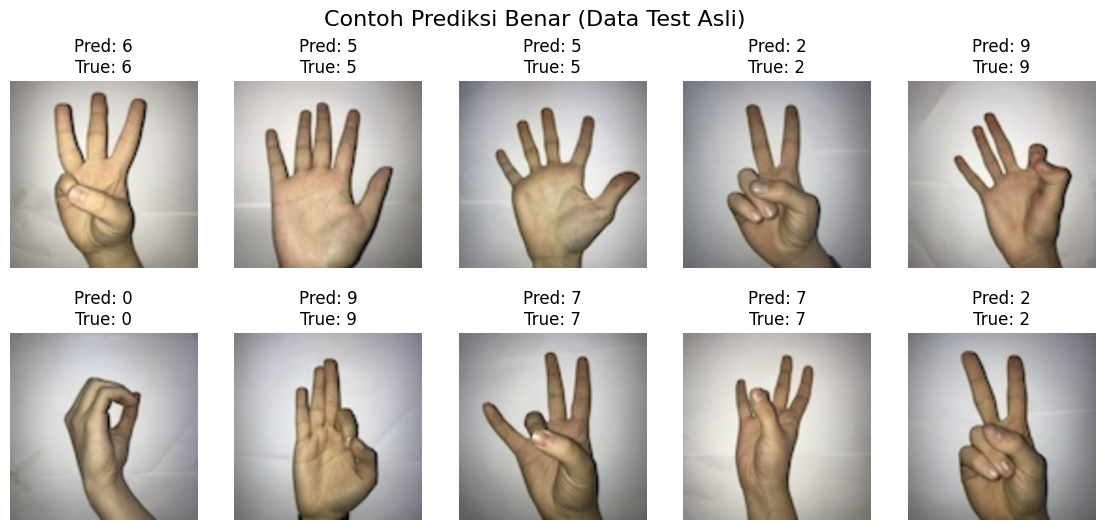

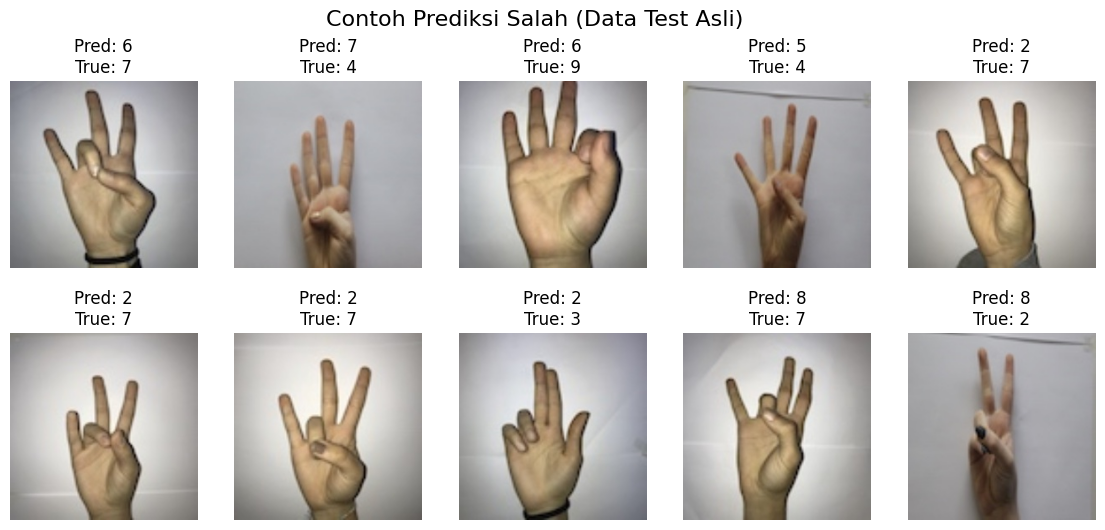

In [ ]:
import random

correct_idx = np.where(predicted_labels_new == test_labels_new)[0]
incorrect_idx = np.where(predicted_labels_new != test_labels_new)[0]

def show_images(indices, title):
    plt.figure(figsize=(14, 6))
    for i, idx in enumerate(random.sample(list(indices), min(10, len(indices)))):
        plt.subplot(2, 5, i + 1)
        img = cv.cvtColor(test_images_new[idx].astype('uint8'), cv.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(f"Pred: {target_class_names[predicted_labels_new[idx]]}\nTrue: {target_class_names[test_labels_new[idx]]}")
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.show()

show_images(correct_idx, "Contoh Prediksi Benar (Data Test Asli)")
show_images(incorrect_idx, "Contoh Prediksi Salah (Data Test Asli)")

# **DATA TEST AUGMENTASI**

In [ ]:
import os
import numpy as np
import cv2 as cv
import pandas as pd
import tensorflow as tf
from sklearn import preprocessing
from sklearn.metrics import (
    confusion_matrix, classification_report,
    accuracy_score, precision_score, recall_score, f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
model_path = "/content/drive/MyDrive/Skripsi_Dataset/Model Baru/VGG16_TL_TrainAug.keras"
test_new_dir = "/content/drive/MyDrive/Skripsi_Dataset/Dataset_Augmented/Data_Test"

In [ ]:
print("Memuat model yang sudah dilatih...")
model = tf.keras.models.load_model(model_path)
print("Model berhasil dimuat!")

Memuat model yang sudah dilatih...
Model berhasil dimuat!


In [ ]:
key_value_test_new = dict()
for i in os.listdir(test_new_dir):
    key_value_test_new[i] = os.listdir(os.path.join(test_new_dir, i))

In [ ]:
df_test_new = []
for key in key_value_test_new.keys():
    for j in key_value_test_new[key]:
        df_test_new.append([key, os.path.join(test_new_dir, key, j)])
df_test_new = pd.DataFrame(df_test_new, columns=('label', 'path'))
print("Total gambar test baru:", len(df_test_new))

Total gambar test baru: 413


In [ ]:
def readimg(path):
    img = cv.imread(path)
    img = cv.resize(img, (224, 224))
    return img

In [ ]:
import multiprocessing
with multiprocessing.Pool(4) as p:
    test_images_new = p.map(readimg, df_test_new['path'])

test_images_new = np.array(test_images_new, dtype='float')

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(df_test_new['label'])
test_labels_new = le.transform(df_test_new['label'])

In [ ]:
print("\n Melakukan prediksi pada data test augmentasi...")
predictions_new = model.predict(test_images_new)
predicted_labels_new = np.argmax(predictions_new, axis=1)


 Melakukan prediksi pada data test augmentasi...
13/13 ━━━━━━━━━━━━━━━━━━━━ 255s 19s/step


In [ ]:
accuracy = accuracy_score(test_labels_new, predicted_labels_new)
precision = precision_score(test_labels_new, predicted_labels_new, average='macro')
recall = recall_score(test_labels_new, predicted_labels_new, average='macro')
f1 = f1_score(test_labels_new, predicted_labels_new, average='macro')

In [ ]:
print("\n=== HASIL EVALUASI DATA TEST AUGMENTASI ===")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-Score : {f1:.4f}")


=== HASIL EVALUASI DATA TEST AUGMENTASI ===
Accuracy : 0.9056
Precision: 0.9062
Recall   : 0.9071
F1-Score : 0.9061


In [ ]:
target_class_names = le.classes_
print("\nClassification Report:")
print(classification_report(test_labels_new, predicted_labels_new, target_names=target_class_names, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.9583    0.9787    0.9684        47
           1     0.9189    0.9714    0.9444        35
           2     0.9048    0.8837    0.8941        43
           3     0.9024    0.9024    0.9024        41
           4     0.9512    0.9286    0.9398        42
           5     0.9756    1.0000    0.9877        40
           6     0.9143    0.8649    0.8889        37
           7     0.7778    0.7955    0.7865        44
           8     0.8750    0.7955    0.8333        44
           9     0.8837    0.9500    0.9157        40

    accuracy                         0.9056       413
   macro avg     0.9062    0.9071    0.9061       413
weighted avg     0.9055    0.9056    0.9050       413



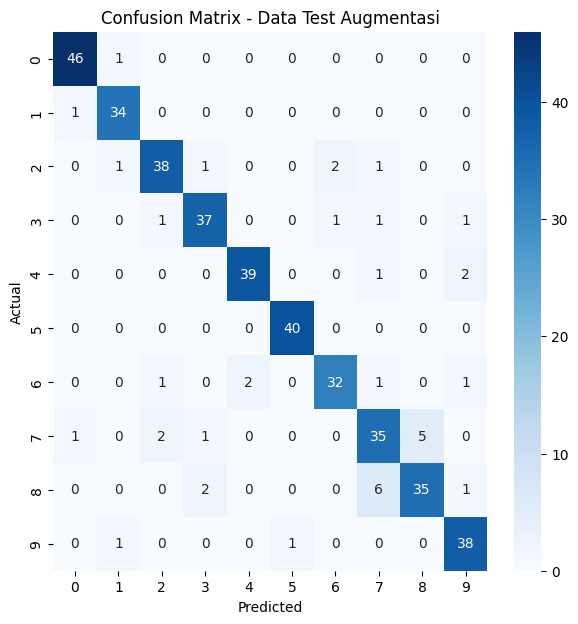

In [ ]:
plt.figure(figsize=(7,7))
cm = confusion_matrix(test_labels_new, predicted_labels_new)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g',
            xticklabels=target_class_names,
            yticklabels=target_class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Data Test Augmentasi")
plt.show()

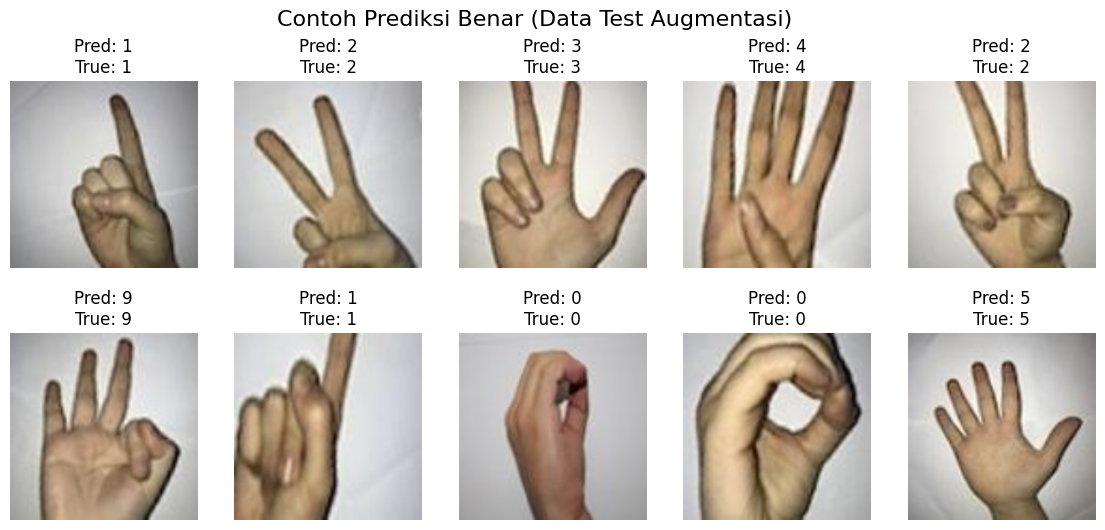

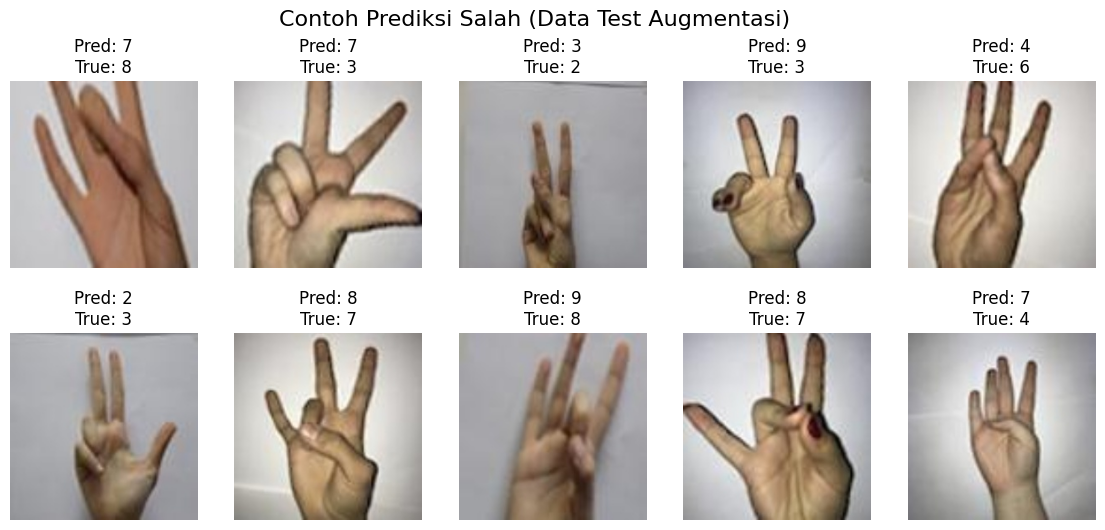

In [ ]:
import random

correct_idx = np.where(predicted_labels_new == test_labels_new)[0]
incorrect_idx = np.where(predicted_labels_new != test_labels_new)[0]

def show_images(indices, title):
    plt.figure(figsize=(14, 6))
    for i, idx in enumerate(random.sample(list(indices), min(10, len(indices)))):
        plt.subplot(2, 5, i + 1)
        img = cv.cvtColor(test_images_new[idx].astype('uint8'), cv.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(f"Pred: {target_class_names[predicted_labels_new[idx]]}\nTrue: {target_class_names[test_labels_new[idx]]}")
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.show()

show_images(correct_idx, "Contoh Prediksi Benar (Data Test Augmentasi)")
show_images(incorrect_idx, "Contoh Prediksi Salah (Data Test Augmentasi)")

# **DATA TEST GABUNGAN**

In [ ]:
import os
import numpy as np
import cv2 as cv
import pandas as pd
import tensorflow as tf
from sklearn import preprocessing
from sklearn.metrics import (
    confusion_matrix, classification_report,
    accuracy_score, precision_score, recall_score, f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
model_path = "/content/drive/MyDrive/Skripsi_Dataset/Model Baru/VGG16_TL_TrainAug.keras"
test_new_dir = "/content/drive/MyDrive/Skripsi_Dataset/Data Test Gabungan"

In [ ]:
print("Memuat model yang sudah dilatih...")
model = tf.keras.models.load_model(model_path)
print("Model berhasil dimuat!")

Memuat model yang sudah dilatih...
Model berhasil dimuat!


In [ ]:
key_value_test_new = dict()
for i in os.listdir(test_new_dir):
    key_value_test_new[i] = os.listdir(os.path.join(test_new_dir, i))

In [ ]:
df_test_new = []
for key in key_value_test_new.keys():
    for j in key_value_test_new[key]:
        df_test_new.append([key, os.path.join(test_new_dir, key, j)])
df_test_new = pd.DataFrame(df_test_new, columns=('label', 'path'))
print("Total gambar test gabungan:", len(df_test_new))

Total gambar test gabungan: 826


In [ ]:
def readimg(path):
    img = cv.imread(path)
    img = cv.resize(img, (224, 224))
    return img

In [ ]:
import multiprocessing
with multiprocessing.Pool(4) as p:
    test_images_new = p.map(readimg, df_test_new['path'])

test_images_new = np.array(test_images_new, dtype='float')

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(df_test_new['label'])
test_labels_new = le.transform(df_test_new['label'])

In [ ]:
print("\n Melakukan prediksi pada data test gabungan...")
predictions_new = model.predict(test_images_new)
predicted_labels_new = np.argmax(predictions_new, axis=1)


 Melakukan prediksi pada data test gabungan...
26/26 ━━━━━━━━━━━━━━━━━━━━ 26s 551ms/step


In [ ]:
accuracy = accuracy_score(test_labels_new, predicted_labels_new)
precision = precision_score(test_labels_new, predicted_labels_new, average='macro')
recall = recall_score(test_labels_new, predicted_labels_new, average='macro')
f1 = f1_score(test_labels_new, predicted_labels_new, average='macro')

In [ ]:
print("\n=== HASIL EVALUASI DATA TEST GABUNGAN ===")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-Score : {f1:.4f}")


=== HASIL EVALUASI DATA TEST GABUNGAN ===
Accuracy : 0.9092
Precision: 0.9090
Recall   : 0.9109
F1-Score : 0.9096


In [ ]:
target_class_names = le.classes_
print("\nClassification Report:")
print(classification_report(test_labels_new, predicted_labels_new, target_names=target_class_names, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.9688    0.9894    0.9789        94
           1     0.9452    0.9857    0.9650        70
           2     0.8652    0.8953    0.8800        86
           3     0.9277    0.9390    0.9333        82
           4     0.9500    0.9048    0.9268        84
           5     0.9750    0.9750    0.9750        80
           6     0.8701    0.9054    0.8874        74
           7     0.7975    0.7159    0.7545        88
           8     0.8667    0.8864    0.8764        88
           9     0.9241    0.9125    0.9182        80

    accuracy                         0.9092       826
   macro avg     0.9090    0.9109    0.9096       826
weighted avg     0.9083    0.9092    0.9083       826



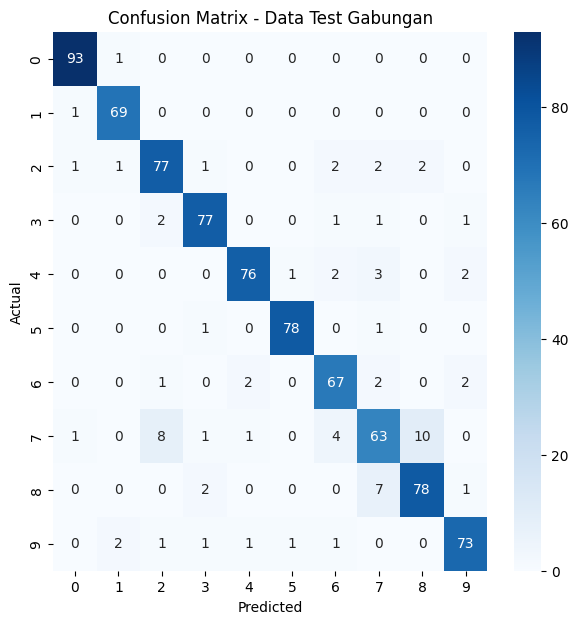

In [ ]:
plt.figure(figsize=(7,7))
cm = confusion_matrix(test_labels_new, predicted_labels_new)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g',
            xticklabels=target_class_names,
            yticklabels=target_class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Data Test Gabungan")
plt.show()

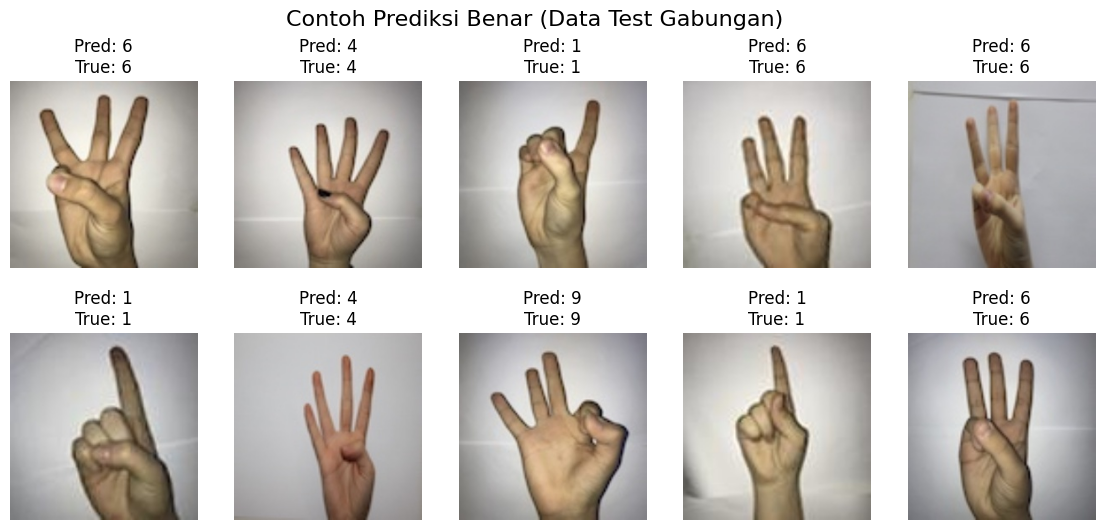

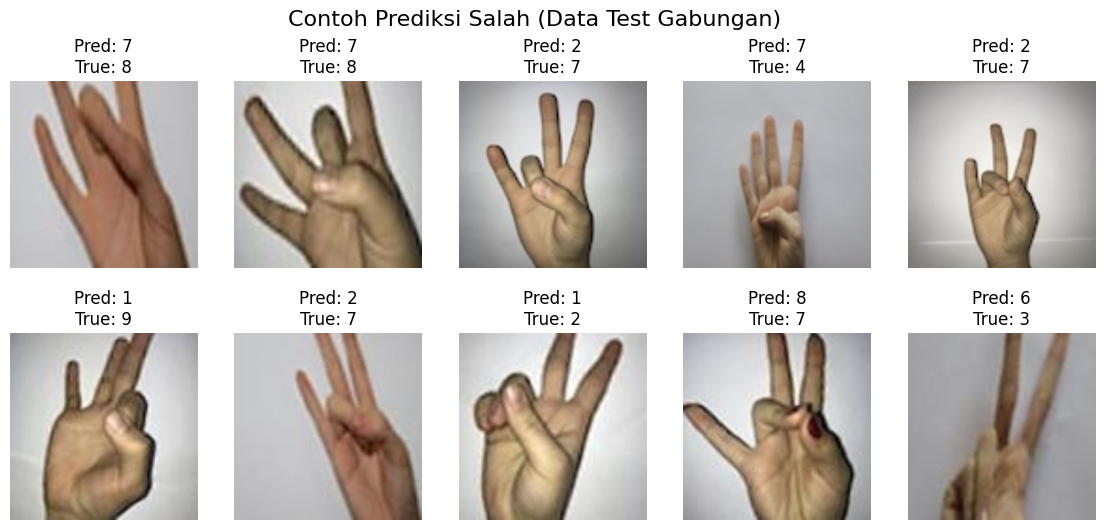

In [ ]:
import random

correct_idx = np.where(predicted_labels_new == test_labels_new)[0]
incorrect_idx = np.where(predicted_labels_new != test_labels_new)[0]

def show_images(indices, title):
    plt.figure(figsize=(14, 6))
    for i, idx in enumerate(random.sample(list(indices), min(10, len(indices)))):
        plt.subplot(2, 5, i + 1)
        img = cv.cvtColor(test_images_new[idx].astype('uint8'), cv.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(f"Pred: {target_class_names[predicted_labels_new[idx]]}\nTrue: {target_class_names[test_labels_new[idx]]}")
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.show()

show_images(correct_idx, "Contoh Prediksi Benar (Data Test Gabungan)")
show_images(incorrect_idx, "Contoh Prediksi Salah (Data Test Gabungan)")